# BRAN2020 data catalogue demo
### a single `intake-esm` catalog

Date: 29 August, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.

### Compute using 4 CPU ARE cluster at NCI
cost = 5 SUs per hour = 20 cents per hour <br>
loading & calculation total walltime = less than one minute

#### required packages

In [1]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### start a local Dask client

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41337,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:46715,Total threads: 1
Dashboard: /proxy/39225/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39535,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [4]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [5]:
catalog_path

'/g/data/v14/tm4888/code/BRAN2020-intake-catalog/catalogs/'

In [6]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [7]:
BRAN2020_catalog

,unique
source,1
domain,4
time_period,4
variable,142
path,8949
derived_variable,0


In [8]:
BRAN2020_catalog.unique()['source']

['BRAN2020']

In [9]:
BRAN2020_catalog.unique()['domain']

['atm', 'ice', 'ocean', 'grid']

In [10]:
BRAN2020_catalog.unique()['time_period']

['annual', 'daily', 'month', 'static']

In [11]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

        BRAN2020 Variables
0                  angle_C
1                  angle_E
2                  angle_N
3                  angle_T
4                   area_C
5                   area_E
6                   area_N
7                   area_T
8                    bmf_u
9                    bmf_v
10                 depth_t
11              ds_00_01_C
12              ds_00_01_E
13              ds_00_01_N
14              ds_00_01_T
15              ds_00_02_C
16              ds_00_02_E
17              ds_00_02_N
18              ds_00_02_T
19              ds_00_10_C
20              ds_00_10_E
21              ds_00_10_N
22              ds_00_10_T
23              ds_00_20_C
24              ds_00_20_E
25              ds_00_20_N
26              ds_00_20_T
27              ds_01_02_C
28              ds_01_02_E
29              ds_01_02_N
30              ds_01_02_T
31              ds_01_11_C
32              ds_01_11_E
33              ds_01_11_N
34              ds_01_11_T
35              ds_01_21_C
3

In [12]:
search_uv = BRAN2020_catalog.search(variable=['u','v'])

In [13]:
search_uv.unique()['variable']

['u', 'v']

In [14]:
search_uv

,unique
source,1
domain,1
time_period,3
variable,2
path,1512
derived_variable,0


In [15]:
search_uv.df

,source,domain,time_period,variable,path
0,BRAN2020,ocean,annual,[u],/g/data/gb6/BRAN/BRAN2020/annual/ocean_u_ann_1...
1,BRAN2020,ocean,annual,[u],/g/data/gb6/BRAN/BRAN2020/annual/ocean_u_ann_1...
2,BRAN2020,ocean,annual,[u],/g/data/gb6/BRAN/BRAN2020/annual/ocean_u_ann_1...
3,BRAN2020,ocean,annual,[u],/g/data/gb6/BRAN/BRAN2020/annual/ocean_u_ann_1...
4,BRAN2020,ocean,annual,[u],/g/data/gb6/BRAN/BRAN2020/annual/ocean_u_ann_1...
...,...,...,...,...,...
1507,BRAN2020,ocean,month,[v],/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth_20...
1508,BRAN2020,ocean,month,[v],/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth_20...
1509,BRAN2020,ocean,month,[v],/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth_20...
1510,BRAN2020,ocean,month,[v],/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth_20...


# search on variable and time period

# Out of some 9000 files we now have narrowed down the 720 that have just the information we need

In [16]:
search_uv_month = BRAN2020_catalog.search(variable=['u','v'],time_period='month')
search_uv_month

,unique
source,1
domain,1
time_period,1
variable,2
path,720
derived_variable,0


# We can now load all that data into a single 720GB "lazy" `xarray` object for further reduction and analysis
## Size is reduced from 16TB to 720GB

In [17]:
%%time
DS = search_uv_month.to_dask()

CPU times: user 4.51 s, sys: 664 ms, total: 5.17 s
Wall time: 11.1 s


In [18]:
DS

<xarray.Dataset>
Dimensions:   (Time: 360, st_ocean: 51, yu_ocean: 1500, xu_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 0.1 0.2 0.3 0.4 0.5 ... 359.7 359.8 359.9 360.0
  * yu_ocean  (yu_ocean) float64 -74.9 -74.8 -74.7 -74.6 ... 74.7 74.8 74.9 75.0
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * Time      (Time) datetime64[ns] 1993-01-16T12:00:00 ... 2022-12-16T12:00:00
Data variables:
    u         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 51, 1500, 3600), meta=np.ndarray>
    v         (Time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 51, 1500, 3600), meta=np.ndarray>
Attributes:
    NumFilesInSet:                   20
    grid_type:                       regular
    grid_tile:                       N/A
    title:                           BRAN2020
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:domain:         ocean
    intake_esm_attrs:time_period:    month
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          ocean.month

# What we need : a slice of `u` and `v` currents for the GBR

In [19]:
DS_slice = DS.sel(st_ocean= slice(0,300)).sel(xu_ocean=slice(142,160)).sel(yu_ocean=slice(-25,-10)).mean('st_ocean')

In [20]:
DS_slice

<xarray.Dataset>
Dimensions:   (Time: 360, yu_ocean: 151, xu_ocean: 181)
Coordinates:
  * xu_ocean  (xu_ocean) float64 142.0 142.1 142.2 142.3 ... 159.8 159.9 160.0
  * yu_ocean  (yu_ocean) float64 -25.0 -24.9 -24.8 -24.7 ... -10.2 -10.1 -10.0
  * Time      (Time) datetime64[ns] 1993-01-16T12:00:00 ... 2022-12-16T12:00:00
Data variables:
    u         (Time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 151, 181), meta=np.ndarray>
    v         (Time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 151, 181), meta=np.ndarray>

## this selection is reduced to less than 100 MB from the 16TB total

# produce a monthly climatology

In [21]:
%%time
clim_uv = DS_slice.groupby('Time.month').mean(method="cohorts", engine="flox")

CPU times: user 446 ms, sys: 66.4 ms, total: 512 ms
Wall time: 1.13 s


In [22]:
clim_uv

<xarray.Dataset>
Dimensions:   (month: 12, yu_ocean: 151, xu_ocean: 181)
Coordinates:
  * xu_ocean  (xu_ocean) float64 142.0 142.1 142.2 142.3 ... 159.8 159.9 160.0
  * yu_ocean  (yu_ocean) float64 -25.0 -24.9 -24.8 -24.7 ... -10.2 -10.1 -10.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u         (month, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 151, 181), meta=np.ndarray>
    v         (month, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 151, 181), meta=np.ndarray>

# This has reduced the result from a 16TB dataset to 2.5 MB so we can easily compute it into our limited memory

In [23]:
%%time
clim_uv = clim_uv.compute()

CPU times: user 16.3 s, sys: 1.75 s, total: 18 s
Wall time: 2min 12s


# TLDR

## For BRAN2020 (1993 - 2022) - compute climatology of ocean currents
### 8 lines of code and less than a minute of NCI ARE walltime costing 20 cents per hour

CPU times: user 6.74 s, sys: 486 ms, total: 7.23 s
Wall time: 24.2 s


Text(0.5, 1.0, 'BRAN2020 current speed\n August climatology')

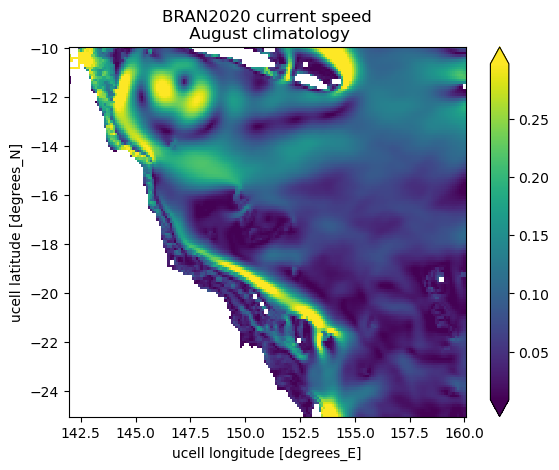

In [27]:
%%time
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json', columns_with_iterables=['variable']) # load catalogue
search_uv_month = BRAN2020_catalog.search(variable=['u','v'],time_period='month') # search and filter data by variables and time period
DS = search_uv_month.to_dask() # load data lazily with Dask
DS_slice = DS.sel(st_ocean= slice(0,300)).sel(xu_ocean=slice(142,160)).sel(yu_ocean=slice(-25,-10)).mean('st_ocean') # slice out reduced XYZ subset required
clim_uv = DS_slice.groupby('Time.month').mean(method="cohorts", engine="flox") ## calculate climatology & chunking rules everything!
speed = np.sqrt(clim_uv.u**2 + clim_uv.v**2) # calculate current speeds
speed.sel(month=8).plot(robust=True) #plot
plt.title('BRAN2020 current speed\n August climatology')

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [25]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

CPU times: user 8.78 ms, sys: 830 µs, total: 9.61 ms
Wall time: 17.8 ms


Text(0.5, 1.0, 'BRAN2020 1993-2022\ncurrent speed \n August Climatology')

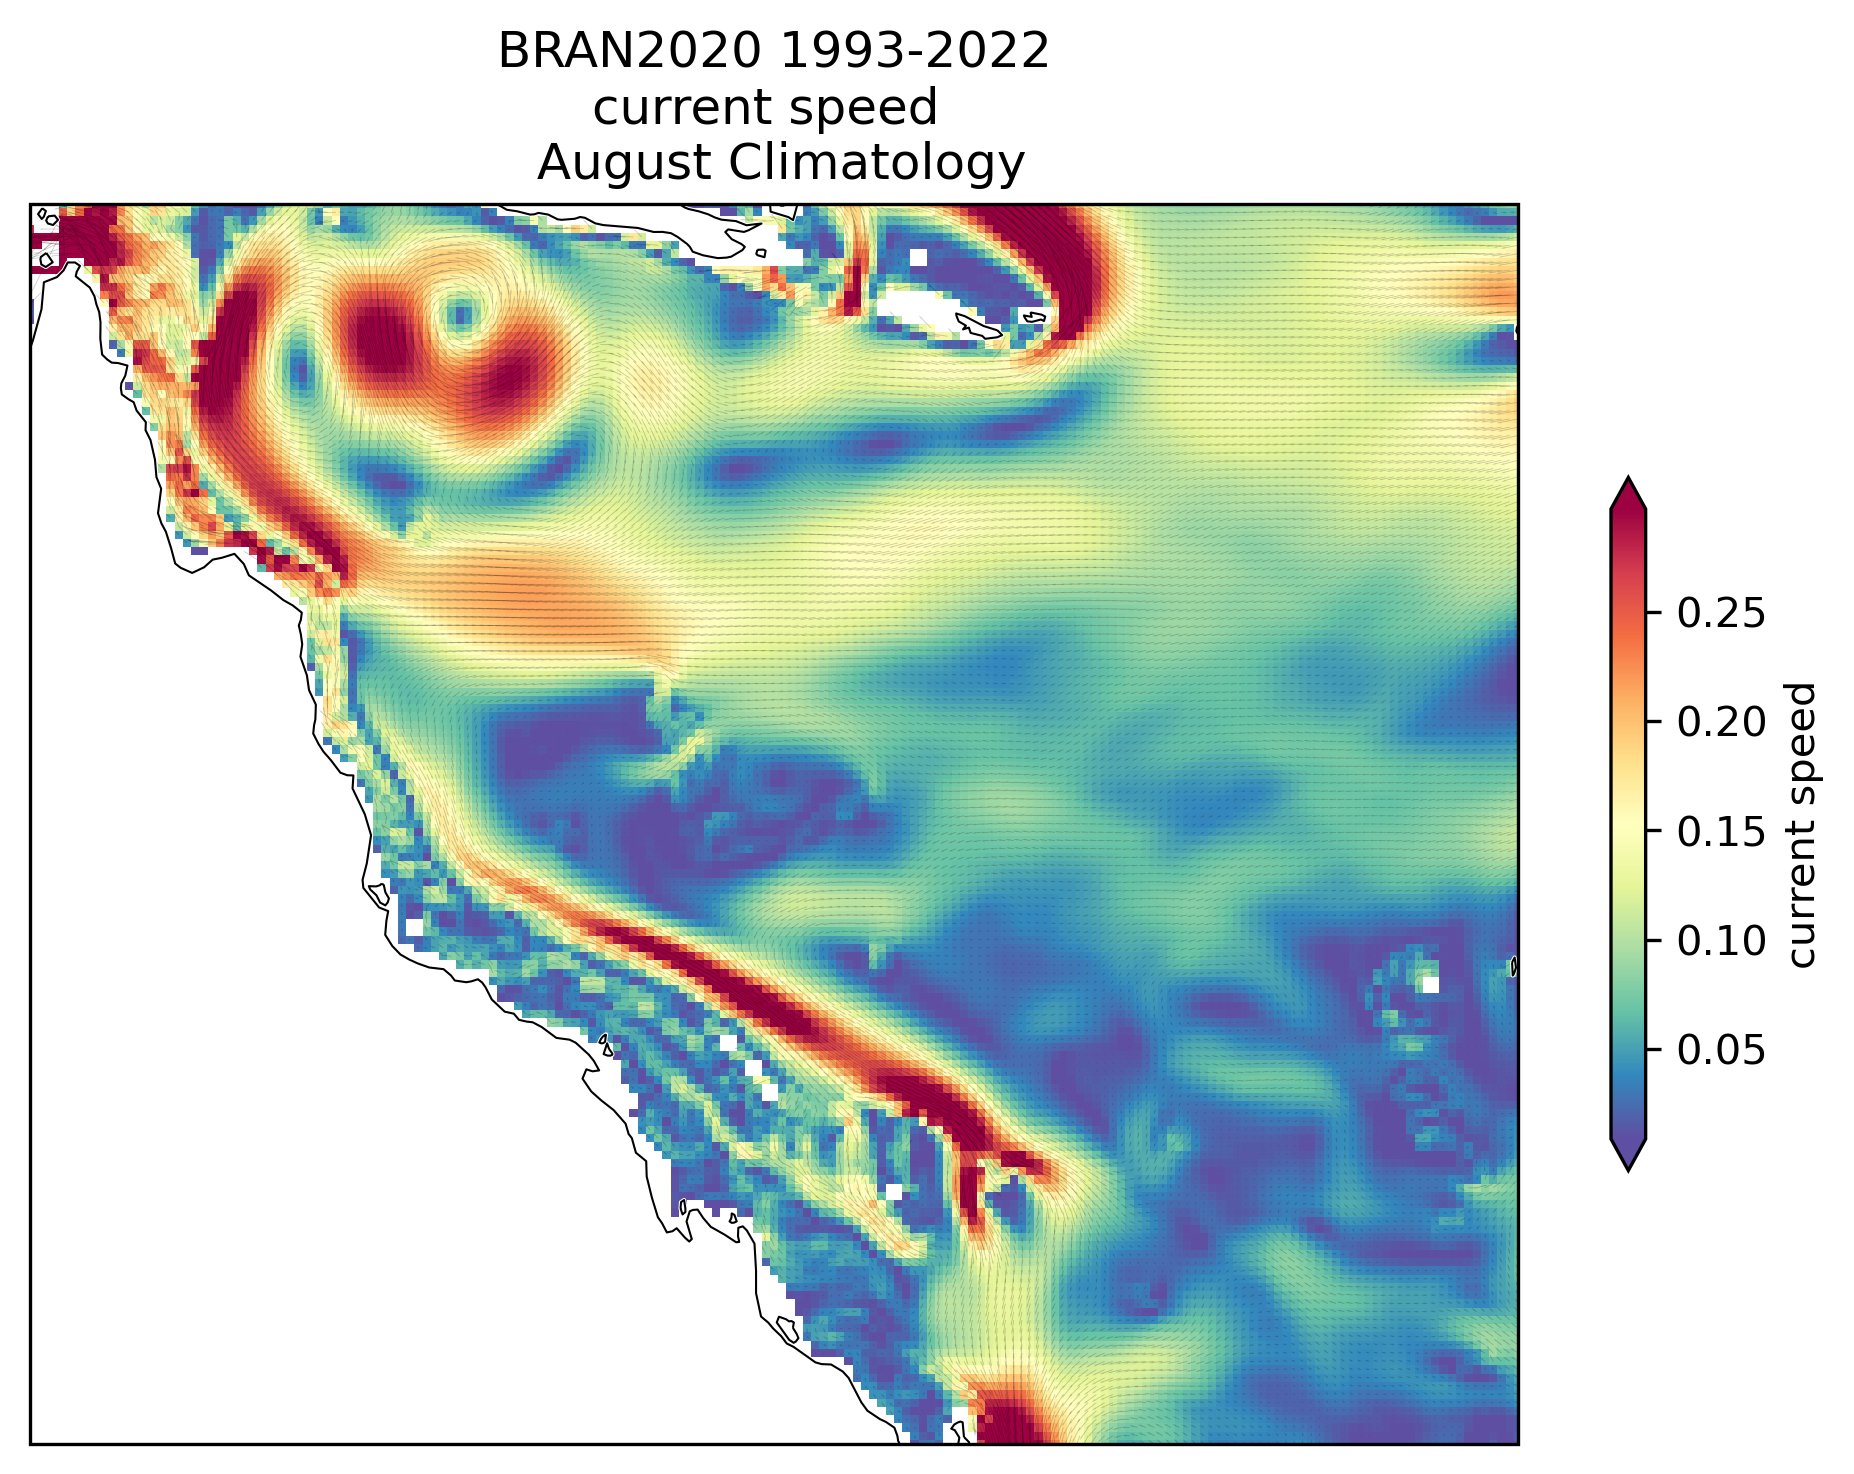

In [26]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')